In [1]:
import sys
import numpy as np
import math
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nLenslet = 26
n = 18
nPx = n*nLenslet+1
print "pupil sampling:      %d pixel"%nPx
detectorRes = 2.0*n*nLenslet/2.0
print "detector resolution: %d pixel"%detectorRes
diam = 26
alpha = 5.0  # radius of circle where GSs are located [in arcmin]
N_GS =  3   # NUMBER of GSs
zenith_angle  = np.ones((1,N_GS))*alpha*ceo.constants.ARCMIN2RAD # in radians
azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
gs    = ceo.Source("R",zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                       rays_box_size=diam,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
#imgr = ceo.ShackHartmann(1, nPx-1, D ,DFT_osf=4,N_PX_IMAGE=0.5*(nPx-1))nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=2,N_GS=N_GS
wfs = ceo.ShackHartmann(nLenslet, n, diam/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=2,N_GS=N_GS)
gmt = ceo.GMT_MX(diam,nPx,M1_radial_order=4)

pupil sampling:      469 pixel
detector resolution: 468 pixel


In [5]:
from scipy.optimize import brentq
def ee80(_psf_,_px_scale_):
    n,m = _psf_.shape
    u = np.linspace(-1,1,n)*(n/2)
    v = np.linspace(-1,1,m)*(m/2)
    x,y = np.meshgrid(u,v)
    def ee80_fun(ee_Delta):
        _ee_Delta_ = (ee_Delta-1)/2
        gate = np.logical_and(np.abs(x)<=_ee_Delta_,np.abs(y)<=_ee_Delta_)
        return np.sum(psf*gate)/(src.nPhoton*368) - 0.8
    try:
        q = brentq(ee80_fun,1,81)*_px_scale_*ceo.constants.RAD2MAS
    except ValueError:
        q = np.float('inf')
    return q

pixel size: 1.27mas


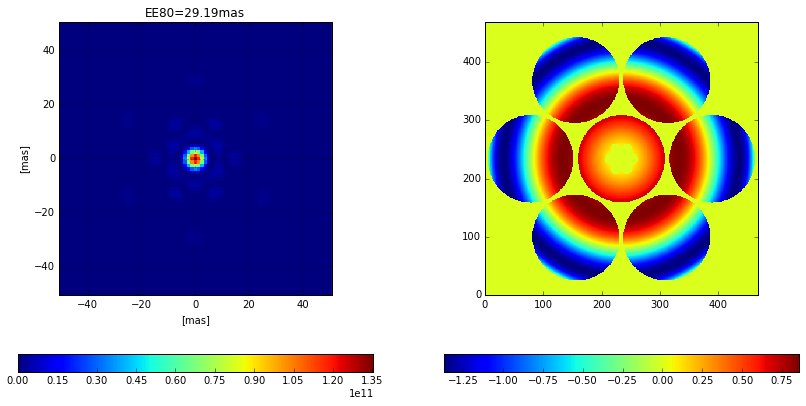

In [6]:
src = ceo.Source("R",rays_box_size=diam,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt.reset()
gmt.propagate(src)
imgr = ceo.Imaging(1, nPx-1,DFT_osf=4,N_PX_IMAGE=81,N_SOURCE=src.N_SRC)
imgr.propagate(src)
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
fig.set_size_inches((14,7))
psf = imgr.frame.host()
px_scale = src.wavelength/(diam*4)
h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ee80_0 = ee80(psf,px_scale)
ax1.set_title("EE80=%.2fmas"%ee80_0)
colorbar(h1,ax=ax1,orientation='horizontal')
h2 = ax2.imshow(src.wavefront.phase.host(shape=(nPx*src.N_SRC,nPx),units='nm').T,interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')
print "pixel size: %.2fmas"%(px_scale*ceo.constants.RAD2MAS)

#Calibrations
## Wavefront sensors

[ 1277.90515137  1278.50878906  1278.47766113]


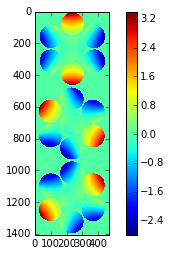

In [7]:
#gmt.M1.update(origin=[0e-6,0.0,0.0],idx=1)
#gs.reset()
gmt.reset()
gs.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
imshow(ps0,interpolation='None')
colorbar()
print gs.wavefront.rms()*1e9
wfs.calibrate(gs,0.8)

In [8]:
print wfs.frame.shape
print "Pixel size: %.3farcsec"%(wfs.BIN_IMAGE*wfs.pixel_scale_arcsec)
print "Field of view: %.3farcsec"%(wfs.BIN_IMAGE*wfs.pixel_scale_arcsec*wfs.N_PX_LENSLET)

(1404, 468)
Pixel size: 0.132arcsec
Field of view: 2.376arcsec


12000.4795761
12000.4795761
11059.1863685
13332.7780577


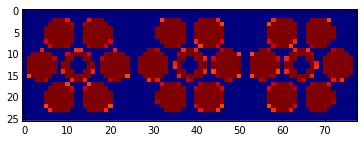

In [11]:
imshow(wfs.flux.host().T,interpolation='none')
print src.nPhoton*1e-9*368*3
print gs.nPhoton*1e-9*368
wfs.analyze(gs)
print wfs.flux.host().sum()*1e-9
print wfs.frame.host().sum()*1e-9

## M2 tip-tilt

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------
M2 tip-tilt interaction matrix condition #:   1.10


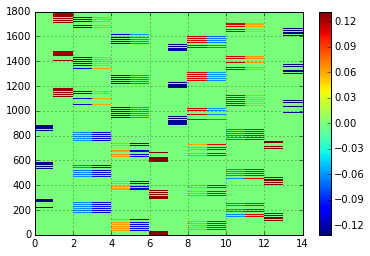

In [12]:
D2tt = gmt.calibrate(wfs,gs,mirror="M2",mode="segment tip-tilt",stroke=200*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D2tt)
colorbar(h)
grid()
print "M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D2tt)

## M2 x,y,z translations with M2 segment tip-til removed

In [13]:
mic2m = 1e-6
def M2_xyz(xyz,segId):
    gmt.reset()
    gmt.M2.update(origin=xyz,idx=segId)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [14]:
def M2_seg_TT(origin=[0,0,0],originId=0):
    M = np.linalg.pinv(D2tt)
    M2_R = np.zeros((14,1))
    for kStep in range(4):
        M2_R += np.dot(M,wfs.valid_slopes.host().T)
    #    print M2_R/mas2rad
    #    print M2_R.shape
        for k in range(7):
            R = [-M2_R[2*k,0],-M2_R[2*k+1,0],0]
            if originId==(k+1):
                gmt.M2.update(origin=origin,euler_angles=R,idx=k+1)
            else:
                gmt.M2.update(euler_angles=R,idx=k+1)
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
#    imshow(1e3*wfs.c.host(shape=(nLenslet*2,nLenslet),units='arcsec').T,interpolation='none')
#    colorbar()
    return wfs.valid_slopes.host().ravel()

In [15]:
stroke = 10
c_shape = (gs.N_SRC*nLenslet*2,nLenslet)
cp_x = cm_x = np.zeros(shape=c_shape)
cp_y = cm_y = np.zeros(shape=c_shape)
cp_z = cm_z = np.zeros(shape=c_shape)
ps_x = ps_y = ps_z = np.zeros(shape=gs.phase.shape)
D2xyz_2 = np.zeros((wfs.n_valid_slopes,3*7))
l = -1
sys.stdout.write("Segment #: ")
for k in range(1,8):
    sys.stdout.write("%d "%k)
    xyz = [stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_x = cp_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    
    ps_x = ps_x + mask*(ps - ps0)
    xyz = [-stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_x = cm_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,stroke*mic2m,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_y = cp_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_y = ps_y + mask*(ps - ps0)
    xyz = [0,-stroke*mic2m,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_y = cm_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,0,stroke*mic2m]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_z = cp_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_z = ps_z + mask*(ps - ps0)
    xyz = [0,0,-stroke*mic2m]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_z = cm_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

Segment #: 1 2 3 4 5 6 7 

<matplotlib.colorbar.Colorbar instance at 0x2b791cbd62d8>

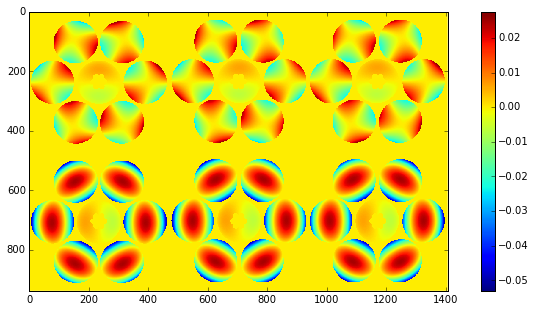

In [16]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
#h2=ax2.imshow(np.concatenate((cp_z,cm_z),axis=1).T,interpolation='none')
h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

<matplotlib.colorbar.Colorbar instance at 0x2b791e3ec098>

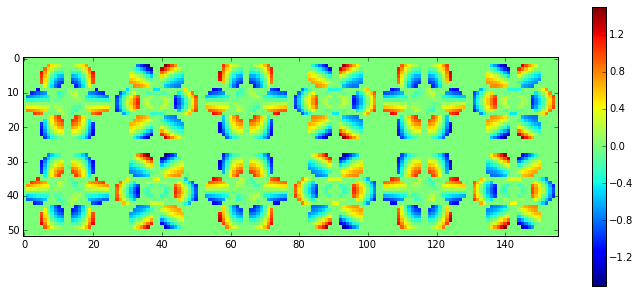

In [17]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
h2=ax2.imshow(np.concatenate((cp_x,cm_x),axis=1).T,interpolation='none')
#h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

M2 x,y,x translation interaction matrix condition #:  41.29


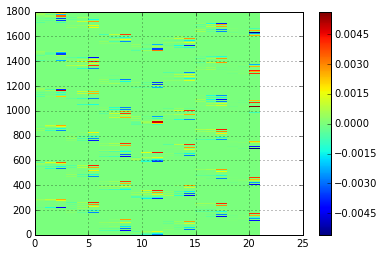

In [18]:
fig, ax = subplots()
h = ax.pcolor(D2xyz_2)
colorbar(h)
grid()
print "M2 x,y,x translation interaction matrix condition #: %6.2f"%np.linalg.cond(D2xyz_2)

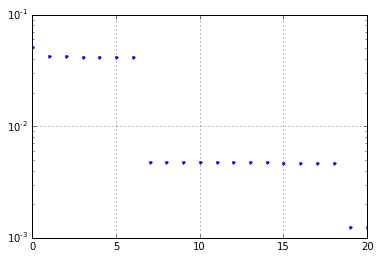

In [19]:
D =  ( D2xyz_2  )
U,S,V = np.linalg.svd(D)
semilogy(S,'.')
grid()

## M1 global tip-tilt with M2 segment tip-til removed

In [20]:
mas2rad = 1e-3*math.pi/180/3600
def M1_global_TT(tip,tilt):
    gmt.reset()
    gmt.M1.global_tiptilt(tip,tilt)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

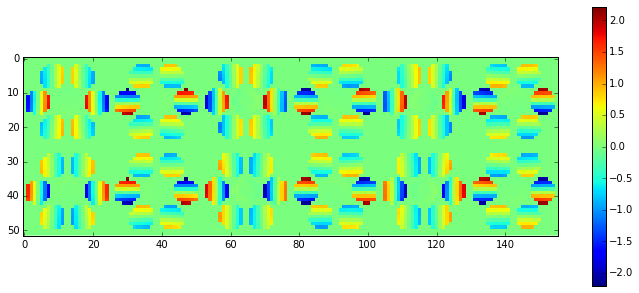

In [21]:
amp = 50*ceo.constants.MAS2RAD
M1_global_TT(amp,0)
sp = M2_seg_TT()
fig, ax2 = subplots()
fig.set_size_inches(12,5)
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*nLenslet*2,nLenslet),units='arcsec')
M1_global_TT(-amp,0)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*nLenslet*2,nLenslet),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2 = np.zeros((wfs.n_valid_slopes,2))
D1gtt_2[:,0] = ((sp-sm)/2)/amp

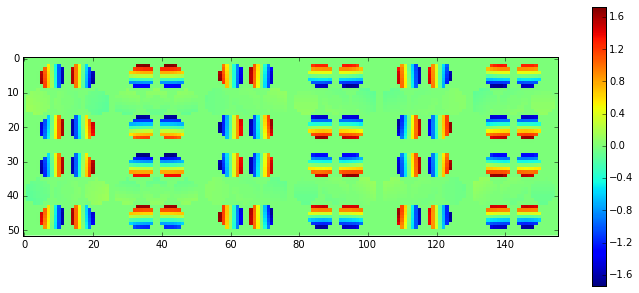

In [22]:
M1_global_TT(0,amp)
sp = M2_seg_TT()
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*nLenslet*2,nLenslet),units='arcsec')
fig, ax2 = subplots()
fig.set_size_inches(12,5)
M1_global_TT(0,-amp)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*nLenslet*2,nLenslet),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2[:,1] = ((sp-sm)/2)/amp

M1 global tip-tilt interaction matrix condition #:   1.01


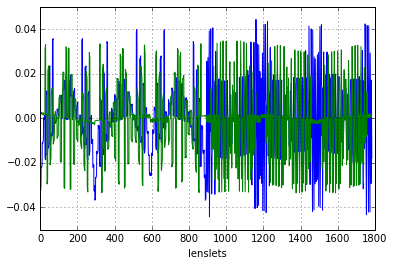

In [23]:
plot(D1gtt_2)
grid()
xlabel('lenslets')
print "M1 global tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D1gtt_2)

## M1 bending modes

In [24]:
mic2m = 1e-6
def M1_zern(zmode,zstroke,segId):
    gmt.reset()
    gmt.M1.zernike.a[segId,zmode] = zstroke
    gmt.M1.zernike.update()
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [25]:
zStroke = 1e-7
l = -1
zmodes = [4,5]
zmodes.extend(range(8,15))
nZernCoefs = len(zmodes)
D1z_2 = np.zeros((wfs.n_valid_slopes,7*nZernCoefs))
ps_z = np.zeros(shape=gs.phase.shape)
for kSeg in range(7):
    sys.stdout.write("Segment #%d: "%kSeg)
    for kMode in zmodes:
        sys.stdout.write("%d "%(kMode+1))
        M1_zern(kMode,zStroke,kSeg)
        sp = M2_seg_TT()
        M1_zern(kMode,-zStroke,kSeg)
        sm = M2_seg_TT()
        l += 1
        D1z_2[:,l] = ((sp-sm)/2)/(zStroke)   
    #ps_z = ps_z + gs.phase.host(units='micron') - ps0
    sys.stdout.write("\n")

Segment #0: 5 6 9 10 11 12 13 14 15 
Segment #1: 5 6 9 10 11 12 13 14 15 
Segment #2: 5 6 9 10 11 12 13 14 15 
Segment #3: 5 6 9 10 11 12 13 14 15 
Segment #4: 5 6 9 10 11 12 13 14 15 
Segment #5: 5 6 9 10 11 12 13 14 15 
Segment #6: 5 6 9 10 11 12 13 14 15 


Zernike modes interaction matrix condition #:   2.81


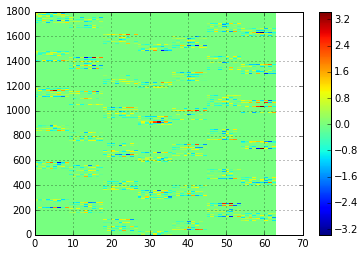

In [26]:
fig, ax = subplots()
h = ax.pcolor(D1z_2)
colorbar(h)
grid()
print "Zernike modes interaction matrix condition #: %6.2f"%np.linalg.cond(D1z_2)

# AGWS closed-loop control

## Resetting

In [27]:
gs.reset()
wfs.reset()
gmt.reset()
ps0 = gs.phase.host(units='nm').T
com1 = np.zeros((23+7*nZernCoefs,1))
com2xyz0 = np.zeros((21,1))
com2xyz0 = np.zeros((21,1))
com1[2:23] = com2xyz0
com2xyz = com1[2:23]
com2 = np.zeros((14,1))
M2 = np.linalg.pinv( D2tt )
D12 = np.concatenate( (D1gtt_2, D2xyz_2, D1z_2) , axis=1)
M12 = np.linalg.pinv( D12 )

## Initial conditions

### M1 global tip-tilt

In [29]:
com10 = np.zeros((23+7*nZernCoefs,1))
com10[:2] = (np.random.rand(2,1)*2-1)*0.1*ceo.constants.ARCSEC2RAD
print array_str(com10[:2]*ceo.constants.RAD2ARCSEC)

[[ 0.04376049]
 [ 0.06066045]]


### M2 x,y and ztranslations

In [30]:
com2xyz0 = (2*np.random.rand(21,1)-1)*50e-6
print array_str(com2xyz0.reshape(7,3)*1e6,precision=2)

[[-39.3   42.69   1.69]
 [-17.22 -37.5  -23.99]
 [ 40.21 -30.89 -39.21]
 [ 39.66  43.58 -17.45]
 [ 20.3   32.66 -26.29]
 [ -6.01  -4.55  31.88]
 [ 37.98 -32.51  16.63]]


### M1 bending modes (Zernike polynomials)

9


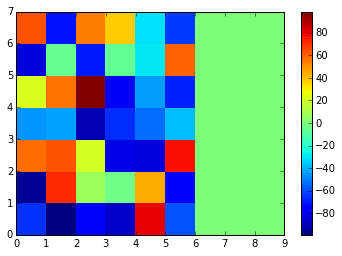

In [31]:
zern_coefs0 = (2*np.random.rand(7,nZernCoefs)-1)*1e-7
zern_coefs0[:,6:] = 0
pcolor(zern_coefs0*1e9)
colorbar()
print nZernCoefs

### M2 segment tip-tilts

In [32]:
com20  = (2*np.random.rand(14,1)-1)*0.25*ceo.constants.ARCSEC2RAD
#com2xyz = np.zeros((21,1))
print array_str(com20.reshape(7,2)*ceo.constants.RAD2MAS,precision=2)

[[-161.2  -213.84]
 [-111.78 -196.24]
 [ 210.73 -101.27]
 [-146.24 -187.07]
 [  25.34  129.19]
 [ 205.02   -9.76]
 [  45.27 -217.17]]


### Noise condition

In [33]:
ron = 0
gs.magnitude = 10.0
print gs.nPhoton*30*368*1e-10

3.600143724


## Initial on-axis PSF and wavefront

3.317733376
3.9960498176
Initial WFE rms: 43503.05nm


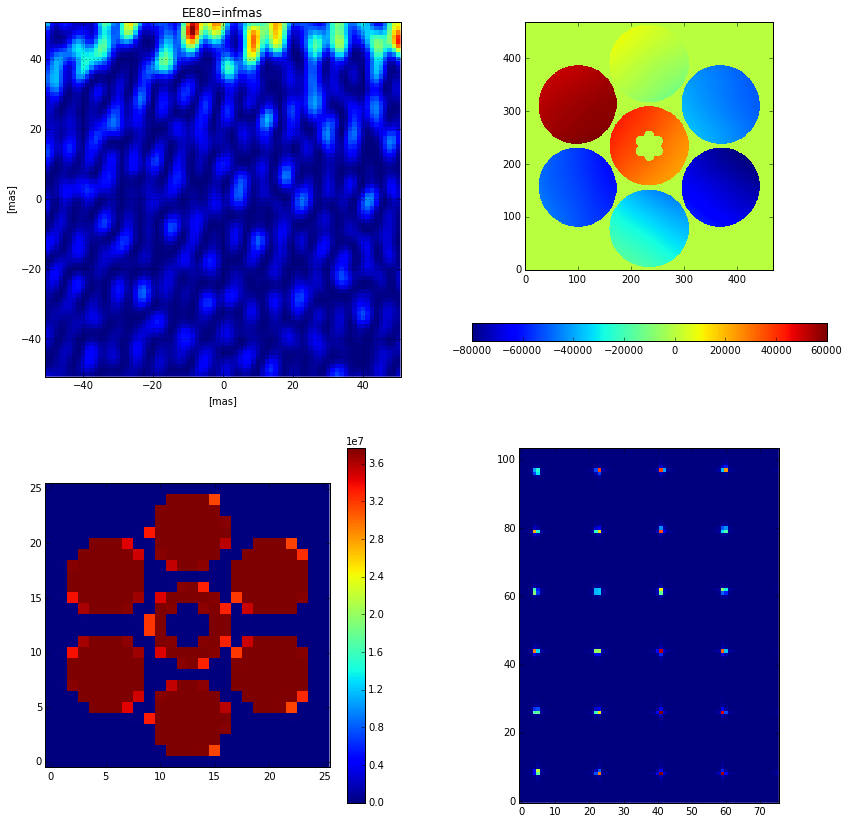

In [43]:
from IPython.display import display, clear_output

gmt.reset()
com1 = np.array( com10 )
gmt.M1.global_tiptilt(com1[0],com1[1])
com1[2:23] = np.array( com2xyz0 )
com2xyz = com1[2:23]
#com1[23:] = np.random.randn(14,1)*1e-7
gmt.M1.zernike.a[:,zmodes] = zern_coefs0
gmt.M1.zernike.update()
com2 = np.array( com20 )
for k in range(7):
    gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                  euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)
    
gs.reset()
wfs.reset()

src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches((14,14))
psf = imgr.frame.host()

h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ax1.set_title("EE80=%.2fmas"%ee80(psf,px_scale))

h2 = ax2.imshow(src.phase.host(units='nm'),interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')

gmt.propagate(gs)
wfs.propagate(gs)
wfs.readOut(30,ron)

h3 = ax3.imshow(wfs.flux.host()[:nLenslet,:],interpolation='none',origin='lower')
colorbar(h3,ax=ax3)
print wfs.flux.host().sum()*1e-10

frame = wfs.frame.host()
h4 = ax4.imshow(frame[40+70:detectorRes/2+20-40,40+20:detectorRes/3+20-40],interpolation='none',origin='lower')
print frame.sum()*1e-10

n1Step = 20
wfe_rms = np.zeros(n1Step+1)
wfe_rms[0] = src.wavefront.rms(-9)
print "Initial WFE rms: %6.2fnm"%wfe_rms[0]

## Closing the loop

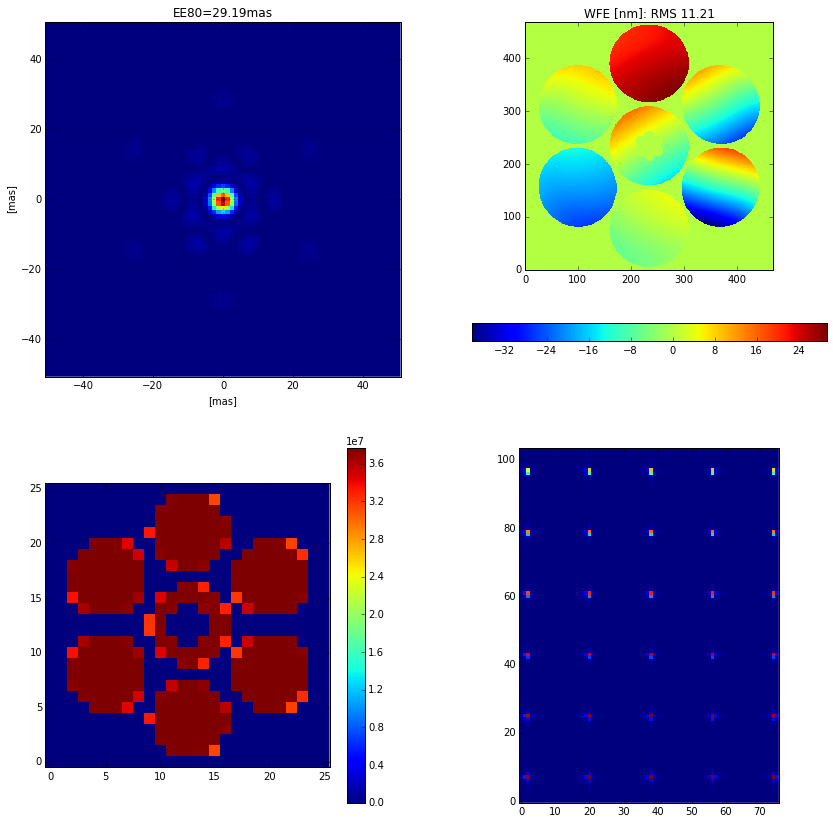

In [44]:
g1 = 0.5
g2 = 0.5
for k1Step in range(n1Step):

    for k2Step in range(10):
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
        com2 -= g2*np.dot(M2,wfs.valid_slopes.host().T)
        for k in range(7):
            gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                          euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.propagate(gs)
    wfs.readOut(30,ron)
    wfs.process()
    #wfs.analyze(gs)

    com1 -= g1*np.dot(M12,wfs.valid_slopes.host().T)
    com2xyz = com1[2:23]
    gmt.M1.global_tiptilt(com1[0],com1[1])
    gmt.M1.zernike.a[:,zmodes] = com1[23:].reshape(7,-1)
    gmt.M1.zernike.update()
    for k in range(7):
        gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                     euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

    src.reset()
    gmt.propagate(src)
    imgr.reset()
    imgr.propagate(src)

    wfe = src.phase.host(units='nm')
    wfe_rms[k1Step+1] = 1e9*src.wavefront.rms()
    psf = imgr.frame.host()

    h1.set_data(psf)
    h1.set_clim((psf.min(),psf.max()))
    ax1.set_title("EE80=%.2fmas"%ee80(psf,px_scale))

    h2.set_data(wfe)
    h2.set_clim((wfe.min(),wfe.max()))
    ax2.set_title( "WFE [nm]: RMS %4.2f"%wfe_rms[k1Step])
    

    h3.set_data(wfs.flux.host()[:nLenslet,:])
    
    frame = wfs.frame.host()
    h4.set_data(frame[40+70:detectorRes/2+20-40,40+20:detectorRes/3+20-40])


    clear_output(wait=True)
    display(fig)
plt.close()

## Wavefront error rms

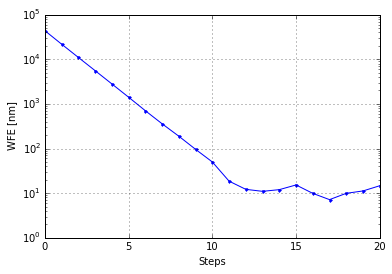

In [45]:
semilogy(wfe_rms,'.-')
grid()
xlabel('Steps')
ylabel('WFE [nm]')